<a id='start'></a>
# Classificazione

In questo notebook vengono presentati degli esercizi sulla Classificazione e sui Decision Tree. <br>
Provate a svolgere il seguente esercizio: <br>
1) [Sopravvivere all'iceberg](#section1)<br>
2) [Predire il diabete](#section2)<br>
3) [Crime in Chicago](#section3)<br>

<a id='section1'></a>
## Sopravvivere all'iceberg

Torniamo ad analizzare i dati dei passeggeri del Titanic. Proviamo a vedere se è possibile realizzare un albero di decisione che ci permetta di discernere chi è morto da chi è sopravvissuto:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

train = pd.read_csv("data/train_dataset_titanic.csv")
train.Sex = train.Sex.map({'female': 1, 'male': 0})
train.Embarked = train.Embarked.map({'C': 0, 'Q': 1, 'S': 2})

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,2.0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,2.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,NaN,2.0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,0.0


In [7]:
# controllo presenza na

feature_names = pd.Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

for col in feature_names:
    c = train[col].isna().sum()
    print("Column %s has %d N/A." % (col, c))

Column Pclass has 0 N/A.
Column Sex has 0 N/A.
Column Age has 177 N/A.
Column SibSp has 0 N/A.
Column Parch has 0 N/A.
Column Fare has 0 N/A.
Column Embarked has 2 N/A.


Utilizziamo la classe [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) di sklearn per modificare i dati non esistenti:

In [8]:
# per riempire valori null

from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')

for col in feature_names:
    train[col] = imp.fit_transform(train[col].values.reshape(-1, 1))

# verifico nuovamente presenza null
for col in feature_names:
    c = train[col].isna().sum()
    print("Column %s has %d N/A." % (col, c))

Column Pclass has 0 N/A.
Column Sex has 0 N/A.
Column Age has 0 N/A.
Column SibSp has 0 N/A.
Column Parch has 0 N/A.
Column Fare has 0 N/A.
Column Embarked has 0 N/A.


Dividiamo i dati tra training e test:

In [9]:
from sklearn.model_selection import train_test_split

train['Survived'] = train.Survived.astype('category')

X = train[feature_names]
X = pd.get_dummies(X, columns=X.columns)  # la funzione dummizza le variabili
y = train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Facciamo la classificazione con il decision tree:

In [10]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Ecco l'albero disegnato con [WebGraphViz](http://webgraphviz.com/):

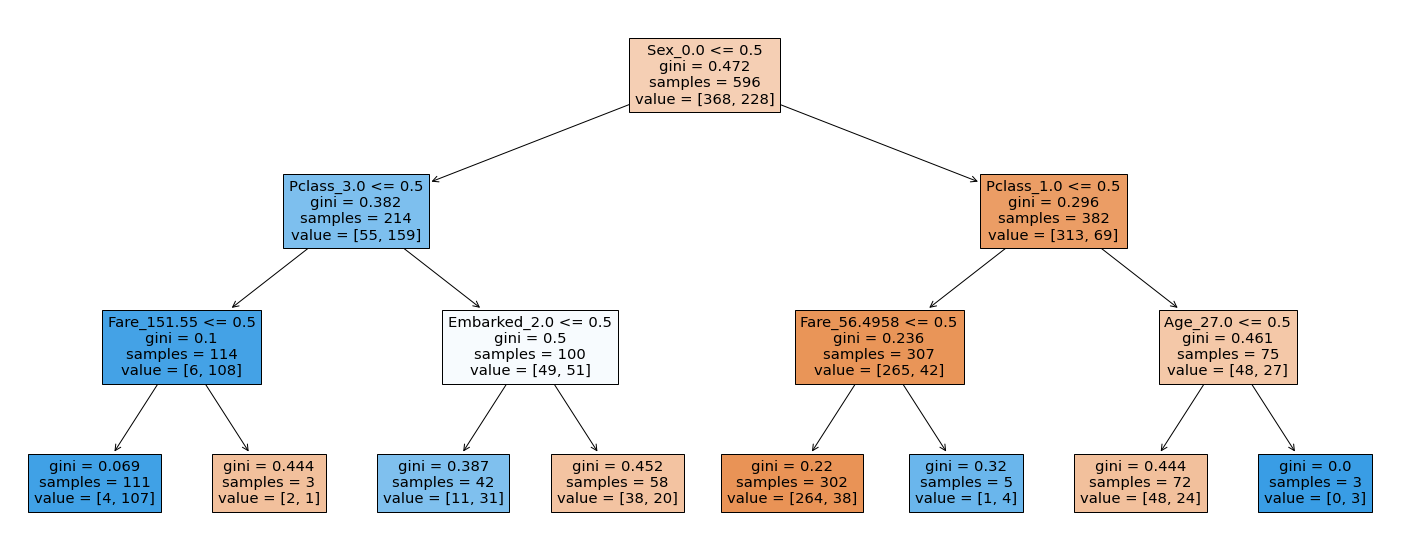

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,
                   filled=True)

/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


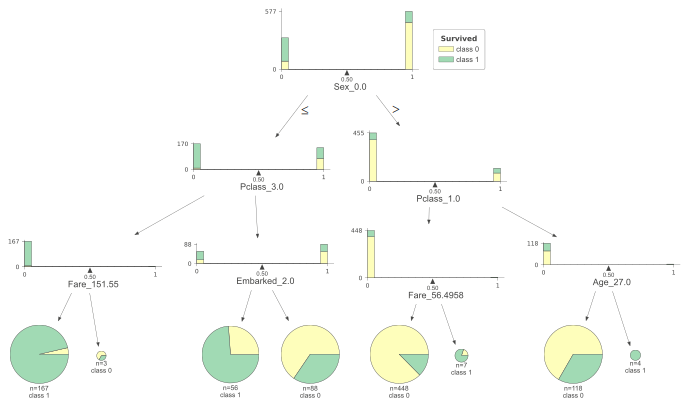

In [12]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(clf, X, y,
               target_name='Survived',
               feature_names=list(X.columns))

viz

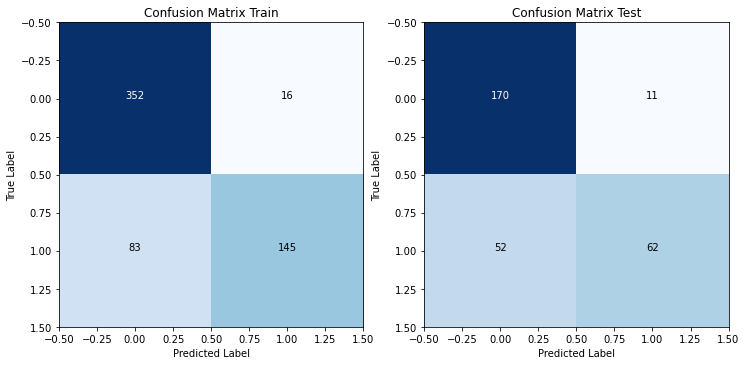

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cf = confusion_matrix(y_train, y_train_hat)
ax1.imshow(cf, cmap=plt.cm.Blues)
ax1.set_title("Confusion Matrix Train")
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    ax1.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

cf = confusion_matrix(y_test, y_test_hat)
ax2.imshow(cf, cmap=plt.cm.Blues)
ax2.set_title("Confusion Matrix Test")
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    ax2.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

plt.show()

Train AUC 0.855
Test AUC 0.821


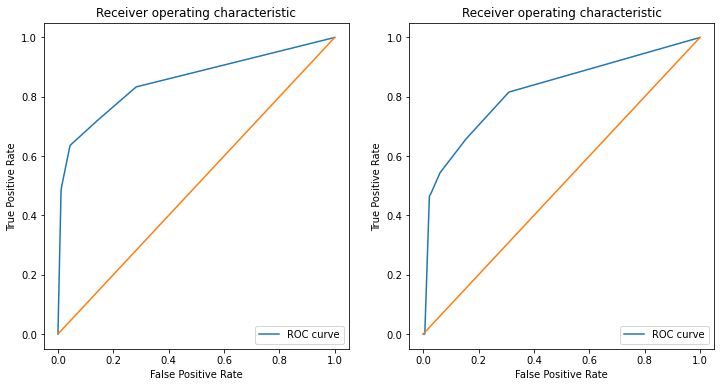

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools

y_test_proba = clf.predict_proba(X_test)
y_train_proba = clf.predict_proba(X_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
fpr, tpr, _ = roc_curve(y_train, y_train_proba[:,1])
roc_auc = auc(fpr, tpr)
print(f'Train AUC {roc_auc:.3f}')

ax1.plot(fpr, tpr, label="ROC curve")
ax1.plot([0, 1], [0, 1])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Receiver operating characteristic")
ax1.legend(loc="lower right")
    
fpr, tpr, _ = roc_curve(y_test, y_test_proba[:,1])
roc_auc = auc(fpr, tpr)
print(f'Test AUC {roc_auc:.3f}')

ax2.plot(fpr, tpr, label="ROC curve")
ax2.plot([0, 1], [0, 1])
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("Receiver operating characteristic")
ax2.legend(loc="lower right")

plt.show()

Proviamo ora a usare XGBoost per predire all'imbarco la probabilità di morte al momento dell'incidente.

Il dataset è così descritto:
- survival - Survival (0 = No; 1 = Yes)
- class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of Siblings/Spouses Aboard
- parch - Number of Parents/Children Aboard
- ticket - Ticket Number
- fare - Passenger Fare
- cabin - Cabin
- embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

Possiamo quindi cercare di prevedere 'survival' partendo da 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'.

Tutte le label sono già numeriche tranne Sex e Embarked, che trasformiamo.

In [29]:
# qui utilizzo un metodo di boosting, un ensemble learning, xgb per cercare di avere migliori performance

X = train[feature_names]
y = train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

xgbtrain = xgb.DMatrix(data=X_train[feature_names],
                       label=y_train.cat.codes,
                       feature_names=feature_names)

xgbtest = xgb.DMatrix(data=X_test[feature_names],
                       label=y_test.cat.codes,
                       feature_names=feature_names)

param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

booster = xgb.train(param, xgbtrain, num_boost_round=num_trees)
predictions = booster.predict(xgbtrain)

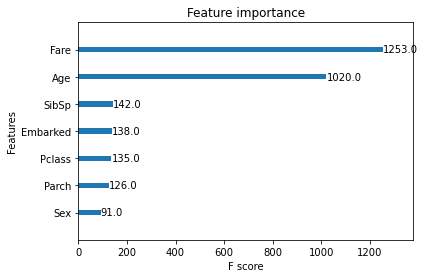

In [30]:
xgb.plot_importance(booster, grid=False)
plt.show()

In [31]:
d = pd.DataFrame()
d['Survived'] = y_train
d['prediction'] = np.around(booster.predict(xgbtrain)).astype('int64')
d[['prediction', 'Survived']]

,prediction,Survived
52,1,1
285,0,0
343,0,0
209,1,1
606,0,0
...,...,...
535,1,1
833,0,0
485,0,0
89,0,0


In [32]:
right = d.loc[d['prediction'] == d['Survived']]
wrong = d.loc[d['prediction'] != d['Survived']]

true_positive = right.loc[right['prediction'] == 1]
false_positive = wrong.loc[wrong['prediction'] == 1]
false_negative = wrong.loc[wrong['prediction'] == 0]

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

print("")

print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))

We had 596 elements in our recordset.
We classified correctly 569 events.
We classified wrongly 27 events.
We had 5 false positive and 22 false negative.

Our precision has been 0.98.
Our recall has been 0.91.


In [33]:
xgbtest = xgb.DMatrix(data=X_test[feature_names],
                       label=y_test.cat.codes,
                       feature_names=feature_names)

d = pd.DataFrame()
d['Survived'] = y_test
d['prediction'] = np.around(booster.predict(xgbtest)).astype('int64')

right = d.loc[d['prediction'] == d['Survived']]
wrong = d.loc[d['prediction'] != d['Survived']]

true_positive = right.loc[right['prediction'] == 1]
false_positive = wrong.loc[wrong['prediction'] == 1]
false_negative = wrong.loc[wrong['prediction'] != 1]

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

print("")

print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))

We had 295 elements in our recordset.
We classified correctly 243 events.
We classified wrongly 52 events.
We had 22 false positive and 30 false negative.

Our precision has been 0.78.
Our recall has been 0.72.


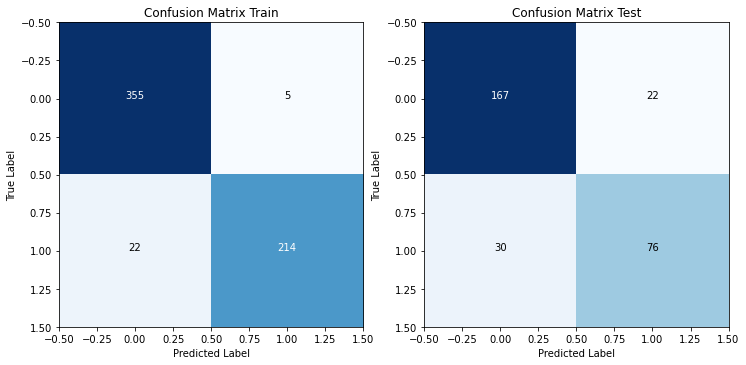

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

y_train_hat = np.around(booster.predict(xgbtrain)).astype('int64')
y_test_hat = np.around(booster.predict(xgbtest)).astype('int64')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cf = confusion_matrix(y_train, y_train_hat)
ax1.imshow(cf, cmap=plt.cm.Blues)
ax1.set_title("Confusion Matrix Train")
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    ax1.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

cf = confusion_matrix(y_test, y_test_hat)
ax2.imshow(cf, cmap=plt.cm.Blues)
ax2.set_title("Confusion Matrix Test")
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    ax2.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

plt.show()

Train AUC 0.991
Test AUC 0.892


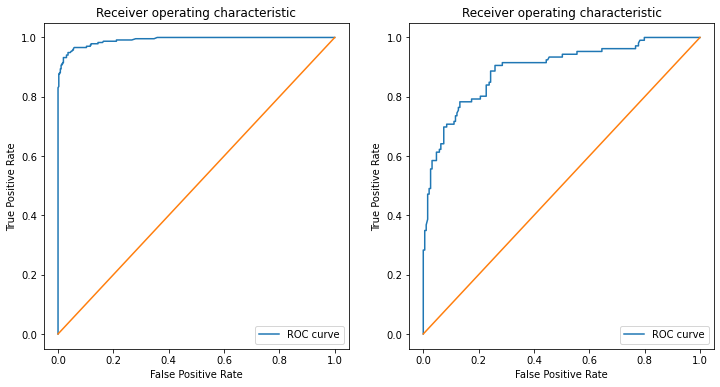

In [40]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools

y_test_proba = booster.predict(xgbtest)
y_train_proba = booster.predict(xgbtrain)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
fpr, tpr, _ = roc_curve(y_train, y_train_proba)
roc_auc = auc(fpr, tpr)
print(f'Train AUC {roc_auc:.3f}')

ax1.plot(fpr, tpr, label="ROC curve")
ax1.plot([0, 1], [0, 1])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Receiver operating characteristic")
ax1.legend(loc="lower right")
    
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
print(f'Test AUC {roc_auc:.3f}')

ax2.plot(fpr, tpr, label="ROC curve")
ax2.plot([0, 1], [0, 1])
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("Receiver operating characteristic")
ax2.legend(loc="lower right")

plt.show()

<a id='section2'></a>
## Predire il diabete

Utilizziamo il dataset `pima-indians-diabetes.data.csv` per provare a predire l'insorgenza di diabete nei pazienti in esso decritti.

In [16]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = pd.read_csv('data/pima-indians-diabetes.csv')
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetePedigreeFunction,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Andiamo a rappresentare il decision tree per vedere come vengono prese in considerazioni le features:

In [17]:
y = dataset[['Class']].copy()
y['Class'] = y['Class'].fillna(0)
y['Class'] = y.Class.astype('category')

X = dataset.drop(['Class'], axis=1)
X = pd.get_dummies(X, columns=X.columns)

High-Dimensionality Score: 0.670995670995671


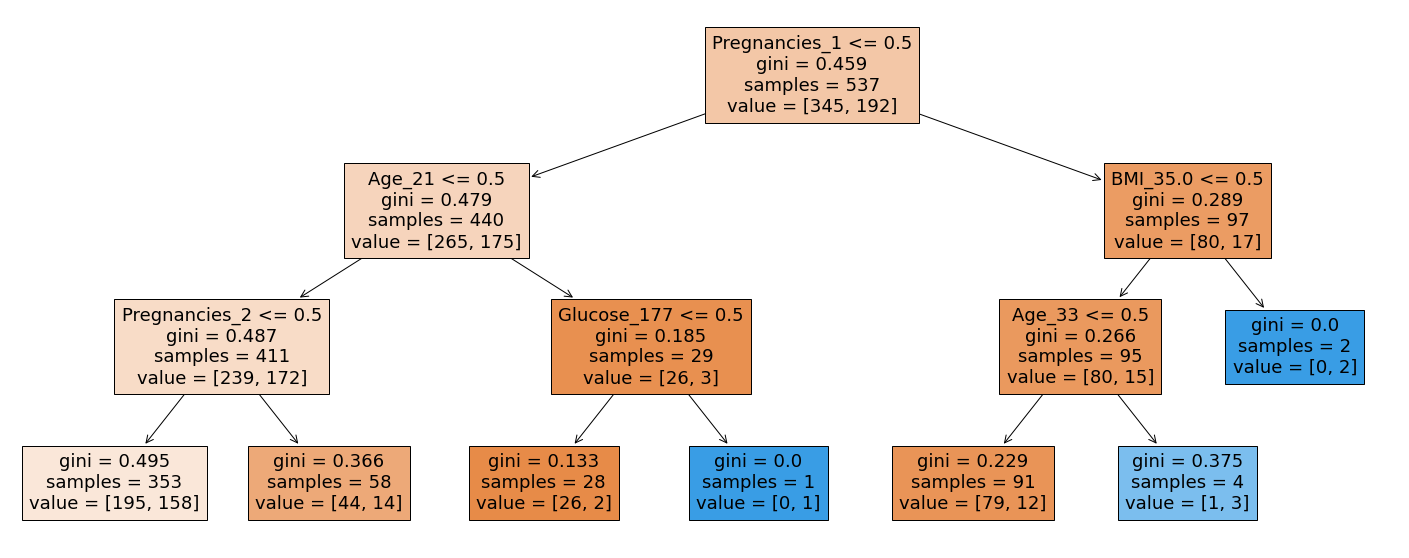

/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


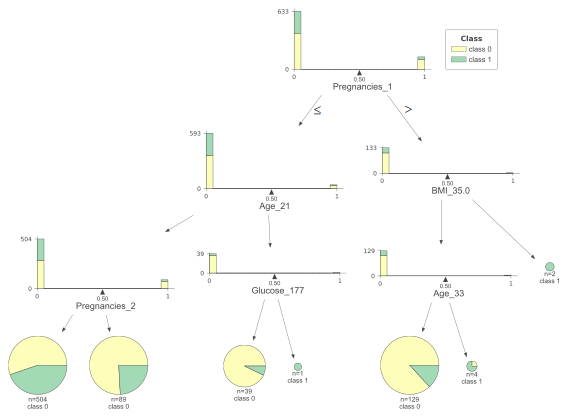

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

dct = DecisionTreeClassifier(max_depth=3)
dct.fit(X_train, y_train)
score = dct.score(X_test, y_test)
print("High-Dimensionality Score:", score)



fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dct, 
                   feature_names=X.columns,
                   filled=True)
plt.show()

viz = dtreeviz(dct, X, y['Class'],
               target_name='Class',
               feature_names=list(X.columns))

viz

Passiamo ora a usare il metodo dei boosted decision tree:

In [19]:
train = xgb.DMatrix(data=X_train,
                    label=y_train['Class'].cat.codes,
                    feature_names=X.columns.tolist())

In [20]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

booster = xgb.train(param, train, num_boost_round=num_trees)
predictions = booster.predict(train)

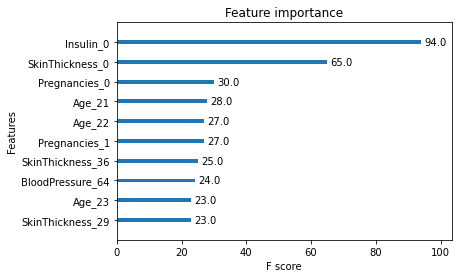

In [21]:
xgb.plot_importance(booster, max_num_features=10, grid=False)
plt.show()

In [22]:
all_data = xgb.DMatrix(data=X,
                    label=y['Class'].cat.codes,
                    feature_names=X.columns.tolist())

d = dataset.copy()
d['Class'] = d['Class'].fillna(0)

d['prediction'] = np.around(booster.predict(all_data)).astype('int64')
d[['prediction', 'Class']]

,prediction,Class
0,1,1
1,0,0
2,1,1
3,0,0
4,1,1
...,...,...
763,1,0
764,0,0
765,0,0
766,0,1


In [23]:
right = d.loc[d['prediction'] == d['Class']]
wrong = d.loc[d['prediction'] != d['Class']]

true_positive = right.loc[right['prediction'] == 's']
false_positive = wrong.loc[wrong['prediction'] == 's']
false_negative = wrong.loc[wrong['prediction'] != 's']

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

We had 768 elements in our recordset.
We classified correctly 615 events.
We classified wrongly 153 events.
We had 0 false positive and 153 false negative.


In [24]:
from sklearn.ensemble import RandomForestClassifier

def create_model(x_train, y_train):
    model = RandomForestClassifier(n_estimators=30, max_depth=10, oob_score=True, random_state=0)
    model.fit(x_train, y_train['Class'])
    
    return model

model = create_model(X_train, y_train)

d = X.copy()
d['Class'] = y
d['prediction'] = model.predict(X)
d[['prediction', 'Class']]

,prediction,Class
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1
...,...,...
763,0,0
764,0,0
765,0,0
766,0,1


In [25]:
right = d.loc[d['prediction'] == d['Class']]
wrong = d.loc[d['prediction'] != d['Class']]

true_positive = right.loc[right['prediction'] == 1]
false_positive = wrong.loc[wrong['prediction'] == 1]
false_negative = wrong.loc[wrong['prediction'] != 1]

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

print("")

print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))

We had 768 elements in our recordset.
We classified correctly 529 events.
We classified wrongly 239 events.
We had 0 false positive and 239 false negative.

Our precision has been 1.00.
Our recall has been 0.11.


<a id='section3'></a>
## Crime in Chicago

Leggiamo i dati dei crimini accaduti a Chicago con le coordinate di latitudine e longitudine e vediamo come è possibile raggrupparli in diverse categorie in base alla posizione dove i crimini sono avvenuti.

In [26]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans

In [27]:
df = pd.read_csv('data/Crimes_-_2001_to_present.csv', header=0)
df

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10002677,HY191890,03/20/2015 01:13:00 PM,020XX W 70TH ST,1661,GAMBLING,GAME/DICE,STREET,True,False,...,17.0,67.0,19,1164027.0,1858234.0,2015,02/10/2018 03:50:01 PM,41.766615,-87.674337,"(41.766615006, -87.674337321)"
1,10003802,HY193541,03/21/2015 06:45:00 PM,042XX W MONROE ST,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,28.0,26.0,19,1148136.0,1899324.0,2015,02/10/2018 03:50:01 PM,41.879691,-87.731530,"(41.879691121, -87.731529667)"
2,10003937,HY193663,03/21/2015 07:55:00 PM,032XX W LAWRENCE AVE,1670,GAMBLING,GAME/AMUSEMENT DEVICE,SMALL RETAIL STORE,True,False,...,39.0,14.0,19,1154071.0,1931710.0,2015,02/10/2018 03:50:01 PM,41.968445,-87.708871,"(41.968444682, -87.708871059)"
3,10004429,HY194332,03/22/2015 01:57:00 PM,019XX S ST LOUIS AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,24.0,29.0,19,1153407.0,1890195.0,2015,02/10/2018 03:50:01 PM,41.854537,-87.712418,"(41.854537081, -87.71241763)"
4,10005837,HY195964,03/23/2015 08:40:00 PM,039XX W CERMAK RD,1661,GAMBLING,GAME/DICE,PARKING LOT/GARAGE(NON.RESID.),True,False,...,24.0,29.0,19,1150290.0,1889088.0,2015,02/10/2018 03:50:01 PM,41.851561,-87.723887,"(41.851560618, -87.723887245)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14262,6536559,HP609082,10/04/2008 06:00:00 PM,039XX W JACKSON BLVD,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,28.0,26.0,19,1150203.0,1898398.0,2008,02/28/2018 03:56:25 PM,41.877110,-87.723964,"(41.87711005, -87.723964016)"
14263,6555032,HP615793,10/08/2008 03:58:00 PM,063XX S FRANCISCO AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,15.0,66.0,19,1158139.0,1862397.0,2008,02/28/2018 03:56:25 PM,41.778161,-87.695806,"(41.778160655, -87.69580613)"
14264,6580599,HP630779,10/16/2008 01:30:00 PM,015XX S KEELER AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,24.0,29.0,19,1148638.0,1892078.0,2008,02/28/2018 03:56:25 PM,41.859798,-87.729873,"(41.859797566, -87.729873421)"
14265,6626933,HP681097,11/13/2008 01:45:30 PM,057XX W AUGUSTA BLVD,1680,GAMBLING,OTHER,SIDEWALK,True,False,...,29.0,25.0,19,1137950.0,1906091.0,2008,02/28/2018 03:56:25 PM,41.898451,-87.768768,"(41.898450542, -87.768768254)"


Vediamo ora se è possibile classificare i dati dei crimini per identificare il crimine più probabile in base agli altri dati nel dataset:

In [28]:
df = df.dropna()

X = df.copy()
X['Description'] = X['Description'].map({
    'GAME/DICE': 'Dice',
    'GAME/AMUSEMENT DEVICE': 'Amusement device',
    'GAME/CARDS': 'Cards',
    'ILLEGAL ILL LOTTERY': 'Illegal lottery'
}).fillna('Other')

X['Description'].value_counts()

Dice                11193
Other                 711
Amusement device      529
Cards                 327
Illegal lottery       294
Name: Description, dtype: int64

In [29]:
from sklearn.utils import resample

X_dice = X[X['Description'] == 'Dice']
X_device = X[X['Description'] == 'Amusement device']
X_cards = X[X['Description'] == 'Cards']
X_lottery = X[X['Description'] == 'Illegal lottery']
X_other = X[X['Description'] == 'Other']
 
# Downsample majority classes
n_samples = X['Description'].value_counts().min()
X_dice = resample(X_dice, replace=False, n_samples=n_samples)
X_other = resample(X_other, replace=False, n_samples=n_samples)
X_device = resample(X_device, replace=False, n_samples=n_samples)
X_cards = resample(X_cards, replace=False, n_samples=n_samples)

# Combine minority class with downsampled majority class
X_resampled = pd.concat([X_dice, X_device, X_cards, X_lottery, X_other])
X_resampled['Description'].value_counts()

Dice                294
Amusement device    294
Cards               294
Illegal lottery     294
Other               294
Name: Description, dtype: int64

Dummizzo tutte le variabili categoriche:

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_dummy = X_resampled.drop(columns=['Description'])
X_dummy = pd.get_dummies(X_dummy, columns=X_dummy.dtypes[X_dummy.dtypes == 'object'].index)

Y = X_resampled['Description']

Ora provo ad effettuare le classificazione:

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

model = RandomForestClassifier(n_estimators=30, max_depth=10, oob_score=True)
model.fit(X_dummy, Y)

Y_pred = model.predict(X_dummy)
Y_pred_proba = model.predict_proba(X_dummy)

print("Accuracy: " + str(accuracy_score(Y, Y_pred)))

Accuracy: 0.7278911564625851


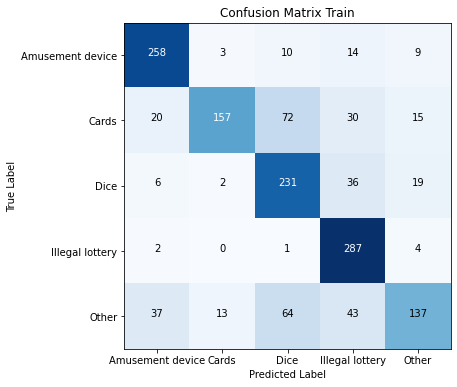

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(12, 6))

target_names = model.classes_
tick_marks = np.arange(len(target_names))

cf = confusion_matrix(Y, Y_pred)
plt.imshow(cf, cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(tick_marks, target_names)
plt.yticks(tick_marks, target_names)

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    plt.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

plt.show()

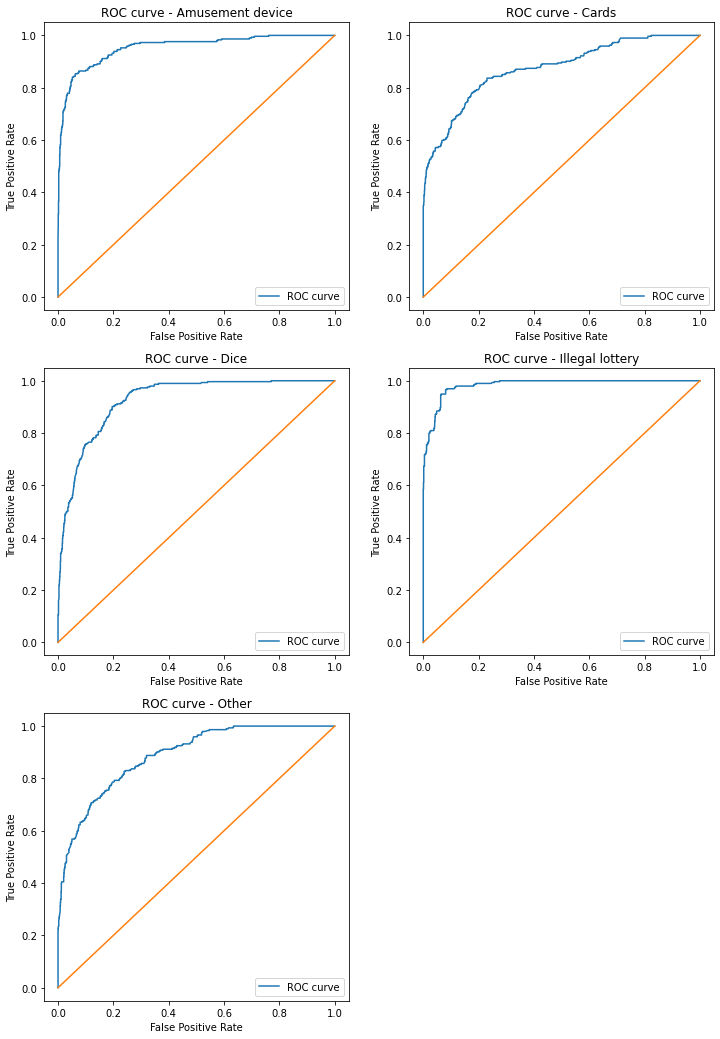

In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 18))
for i in tick_marks:
    fpr, tpr, _ = roc_curve(Y, Y_pred_proba[:,i], pos_label=target_names[i])
    roc_auc = auc(fpr, tpr)

    axes[i//cols, i%cols].plot(fpr, tpr, label='ROC curve')
    axes[i//cols, i%cols].plot([0, 1], [0, 1])
    axes[i//cols, i%cols].set_xlabel('False Positive Rate')
    axes[i//cols, i%cols].set_ylabel('True Positive Rate')
    axes[i//cols, i%cols].set_title(f'ROC curve - {target_names[i]}')
    axes[i//cols, i%cols].legend(loc="lower right")
    
axes[rows-1, cols-1].set_visible(False) 
plt.show()

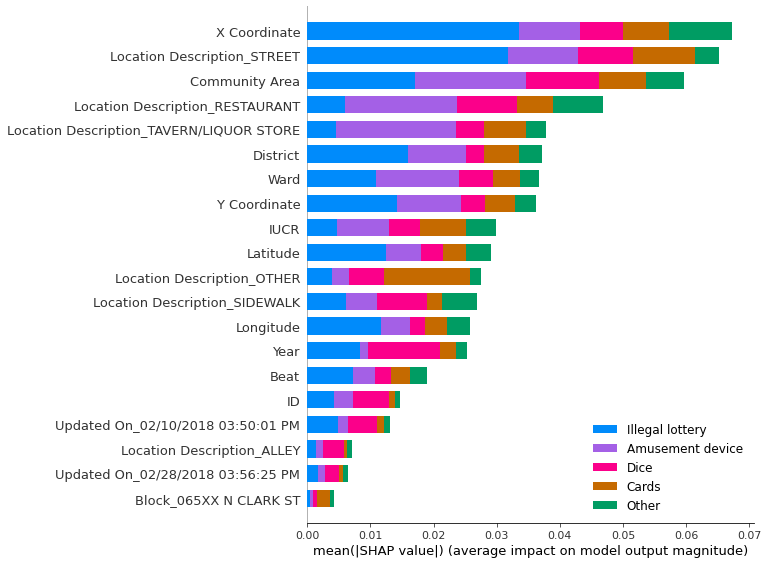

In [34]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_dummy)
shap.summary_plot(shap_values, X_dummy, plot_type="bar", class_names=target_names)

[Clicca qui per tornare all'inizio della pagina](#start)<a id='start'></a>